# Computing the energy of water on IBM

## Set experiment parameters

In [1]:
ibm_computer: str = "ibm_fez"
qubits = [153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 136, 123, 124]
nshots: int = 20_000

len(qubits)

14

## Setup

In [79]:
from collections import Counter
from typing import Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import networkx as nx
import numpy as np
import pickle

from cirq.contrib.qasm_import import circuit_from_qasm
import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

# from mitiq.interface.mitiq_qiskit import to_qiskit

## Read in the Hamiltonian and ansatz circuit

In [3]:
hamiltonian = of.jordan_wigner(
        of.get_fermion_operator(
    of.chem.MolecularData(filename="monomer_eqb.hdf5").get_molecular_hamiltonian()
    )
)
nqubits = of.utils.count_qubits(hamiltonian)
nterms  = len(hamiltonian.terms)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 14 qubit(s) and has 1620 term(s).


In [4]:
water_eqb_circuits = pickle.load(open("./water_eqb_circuits", "rb"))

for error, circuit, layout in water_eqb_circuits:
    print("Error =", error)
    print("Circuit stats:", circuit.count_ops())

Error = 0.037555931951644084
Circuit stats: OrderedDict([('sx', 31), ('rz', 25), ('cz', 15), ('x', 10), ('barrier', 1)])
Error = 0.03379578090144264
Circuit stats: OrderedDict([('sx', 62), ('rz', 50), ('cz', 30), ('x', 10), ('barrier', 2)])
Error = 0.030943222097420175
Circuit stats: OrderedDict([('sx', 112), ('rz', 81), ('cz', 55), ('x', 11), ('barrier', 3)])
Error = 0.027695213747492176
Circuit stats: OrderedDict([('sx', 171), ('rz', 115), ('cz', 82), ('x', 13), ('barrier', 4)])
Error = 0.02339403255849959
Circuit stats: OrderedDict([('sx', 241), ('rz', 149), ('cz', 117), ('x', 13), ('barrier', 5)])
Error = 0.01931645584224384
Circuit stats: OrderedDict([('sx', 299), ('rz', 171), ('cz', 144), ('x', 12), ('barrier', 6)])
Error = 0.01475382803189973
Circuit stats: OrderedDict([('sx', 367), ('rz', 208), ('cz', 179), ('x', 12), ('barrier', 7)])
Error = 0.008882504924585533
Circuit stats: OrderedDict([('sx', 413), ('rz', 225), ('cz', 201), ('x', 12), ('barrier', 8)])
Error = 0.00578208149

In [5]:
error, circuit, layout = water_eqb_circuits[5]
circuit.draw(fold=-1, idle_wires=False)

global phase: π/2
              ┌───┐                                                                                                                                                                                                                                                                                                                                            ░                                                                                                                                                                                                                                                                                                                                                                                                                                           ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ░                                                                                                                                                                                                                                                                                                                                                                                                                                   ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ░ 
 q_13 -> 6 ───┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Preprocessing

### Compile the circuit

In [6]:
base = circuit.copy()

In [7]:
base = qiskit.transpiler.passes.RemoveBarriers()(base)

In [8]:
base = qiskit.transpile(
    base,
    optimization_level=3,
    # initial_layout=qubits,
    seed_transpiler=1,
)
print(base.count_ops())
base.draw(fold=-1, idle_wires=False)

OrderedDict([('cz', 142), ('sx', 136), ('u2', 70), ('u3', 42), ('x', 7), ('u1', 2)])


global phase: 1.5465
            ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  q_6: ─────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            ├───┤                                                                                                                                                                                                                                                                                                                                                  

### Compress the Hamiltonian

In [9]:
# hamiltonian.compress(0.001)

### Generate measurement circuits

In [27]:
import kcommute

In [24]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)

In [44]:
groups = kcommute.get_si_sets(hamiltonian, kcommute.compute_blocks(hamiltonian_cirq.qubits, k=len(qubits)))

In [45]:
len(groups)

65

In [99]:
ham0 = of.qubit_operator_to_pauli_sum(sum(groups[0]))

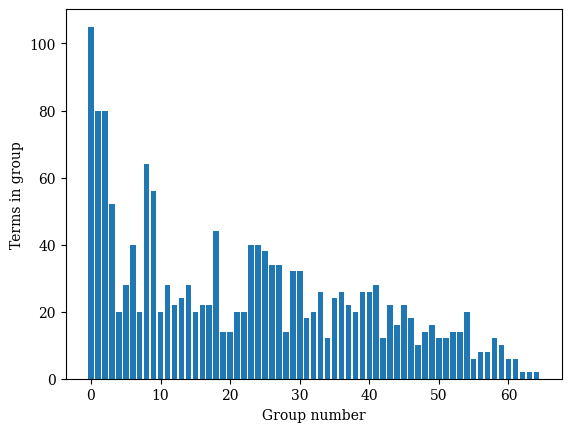

In [46]:
plt.bar(range(len(groups)), [len(group) for group in groups])
plt.xlabel("Group number")
plt.ylabel("Terms in group");

In [47]:
def get_stabilizer_matrix_from_paulis(stabilizers, qubits):
    numq = len(qubits)
    nump = len(stabilizers)
    stabilizer_matrix = np.zeros((2*numq, nump))

    for i, paulistring in enumerate(stabilizers):
        for key, value in paulistring.items():
            if value._name == "X":
                stabilizer_matrix[int(key) + numq, i] = 1
            elif value._name == "Y":
                stabilizer_matrix[int(key), i] = 1
                stabilizer_matrix[int(key) + numq, i] = 1
            elif value._name == "Z":
                stabilizer_matrix[int(key), i] = 1

    return stabilizer_matrix

In [59]:
stabilizer_matrix = get_stabilizer_matrix_from_paulis(of.qubit_operator_to_pauli_sum(sum(groups[0])), hamiltonian_cirq.qubits)
stabilizer_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(28, 105))

In [65]:
from itertools import product
import cirq


def get_measurement_circuit(stabilizer_matrix):
    numq = len(stabilizer_matrix) // 2 # number of qubits
    nump = len(stabilizer_matrix[0]) # number of paulis
    z_matrix = stabilizer_matrix.copy()[:numq]
    x_matrix = stabilizer_matrix.copy()[numq:]

    measurement_circuit = cirq.Circuit()
    qreg = cirq.LineQubit.range(numq)

    # Find a combination of rows to make X matrix have rank nump
    for row_combination in product(['X', 'Z'], repeat=numq):
        candidate_matrix = np.array([
            z_matrix[i] if c=="Z" else x_matrix[i] for i, c in enumerate(row_combination)
        ])

        # Apply Hadamards to swap X and Z rows to transform X matrix to have rank nump
        if np.linalg.matrix_rank(candidate_matrix) == nump:
            for i, c in enumerate(row_combination):
                if c == "Z":
                    z_matrix[i] = x_matrix[i]
                    measurement_circuit.append(cirq.H.on(qreg[i]))
            x_matrix = candidate_matrix
            break
    
    for j in range(nump):
        if x_matrix[j,j] == 0:
            i = j + 1
            while x_matrix[i,j] == 0:
                i += 1

            x_row = x_matrix[i].copy()
            x_matrix[i] = x_matrix[j]
            x_matrix[j] = x_row

            z_row = z_matrix[i].copy()
            z_matrix[i] = z_matrix[j]
            z_matrix[j] = z_row

            measurement_circuit.append(cirq.SWAP.on(qreg[j], qreg[i]))

        for i in range(j + 1, numq):
            if x_matrix[i,j] == 1:
                x_matrix[i] = (x_matrix[i] + x_matrix[j]) % 2
                z_matrix[j] = (z_matrix[j] + z_matrix[i]) % 2

                measurement_circuit.append(cirq.CNOT.on(qreg[j], qreg[i]))

    for j in range(nump-1, 0, -1):
        for i in range(j):
            if x_matrix[i, j] == 1:
                x_matrix[i] = (x_matrix[i] + x_matrix[j]) % 2
                z_matrix[j] = (z_matrix[j] + z_matrix[i]) % 2

                measurement_circuit.append(cirq.CNOT.on(qreg[j], qreg[i]))

    for i in range(nump):
        if z_matrix[i,i] == 1:
            z_matrix[i,i] = 0
            measurement_circuit.append(cirq.S.on(qreg[i]))
        
        for j in range(i):
            if z_matrix[i,j] == 1:
                z_matrix[i,j] = 0
                z_matrix[j,i] = 0
                measurement_circuit.append(cirq.CZ.on(qreg[j], qreg[i]))

    for i in range(nump):
        row = x_matrix[i].copy()
        x_matrix[i] = z_matrix[i]
        z_matrix[i] = row

        measurement_circuit.append(cirq.H.on(qreg[i]))

    return measurement_circuit, np.concatenate((z_matrix, x_matrix))

In [69]:
circuit, mat = get_measurement_circuit(stabilizer_matrix)

IndexError: index 14 is out of bounds for axis 0 with size 14

## Connect to Qiskit runtime service

In [70]:
service = qiskit_ibm_runtime.QiskitRuntimeService() # This assumes a saved account.
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

computer_fractional_gates = service.backend(ibm_computer, use_fractional_gates=True)
sampler_fractional_gates = Sampler(computer_fractional_gates)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-04 23:19:31,272: Default instance not set. Searching all available instances.


## Run experiment

In [71]:
base.measure_active()

In [73]:
compiled = qiskit.transpile(
    base,
    backend=computer,
    # initial_layout=qubits,
)
compiled.draw(fold=-1, idle_wires=False)

global phase: π/2
                 ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ░    ┌─┐                                    
  q_28 -> 50 ────┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [74]:
compiled.count_ops()

OrderedDict([('sx', 285),
             ('rz', 158),
             ('cz', 140),
             ('measure', 14),
             ('x', 9),
             ('barrier', 1)])

In [76]:
to_run = compiled.copy()

In [ ]:
to_run.draw(fold=-1, idle_wires=False)

## Noiseless result

In [80]:
job = AerSimulator().run(to_run, shots=nshots)

In [81]:
counts_all = {np.binary_repr(int(z, 16), len(qubits)): count for z, count in job.result().data().get("counts").items()}
counts_all

{'10101111010111': 19707,
 '01101110110111': 19,
 '10011111001111': 119,
 '01101111001111': 6,
 '01011111010111': 31,
 '11010111010111': 32,
 '10011011110111': 18,
 '10101110101111': 17,
 '11100011110111': 2,
 '11010110101111': 1,
 '11100111001111': 8,
 '10101011101111': 37,
 '01101011110111': 2,
 '10011110110111': 1}

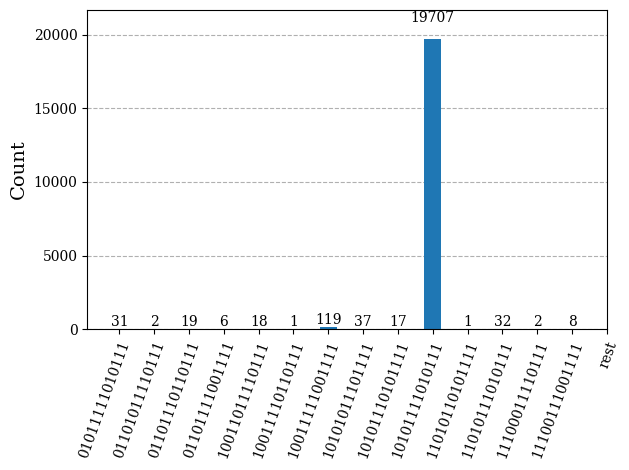

In [93]:
qiskit.visualization.plot_histogram(counts_all, number_to_keep=40)

In [159]:
from typing import Dict
import collections


# def get_counts_for(qubit: int, counts: collections.Counter[str, int]) -> collections.Counter[int, int]:
#     qubit_counts = collections.Counter()
#     for key, value in counts.items():
#         k = list(key)[qubit]
#         qubit_counts[int(k)] += value
#     return qubit_counts


def _compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return pauli.coefficient

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return pauli.coefficient * expectation / sum(counts.values())


def compute_expectation(
    pauli_sum: cirq.PauliSum,
    counts: Dict[str, int],
) -> float:
    expval = 0.0
    for pauli in pauli_sum:
        expval += _compute_expectation(pauli, counts)
    return expval

In [162]:
compute_expectation(ham0, counts_all)

(-26.69060965975106+0j)

In [157]:
def get_counts_for(counts: dict[str, int], *qubits) -> Counter:
    new = Counter()
    for bitstring, number in counts.items():
        subselected = "".join(bitstring[q] for q in qubits)
        new[subselected] += number
    return new

In [158]:
get_counts_for(counts_all, 0, 1)

Counter({'10': 19899, '01': 58, '11': 43})

In [ ]:
qubit1 = 2
qubit2 = 3

In [ ]:
counts = get_counts_for(counts_all, qubit1, qubit2)

In [ ]:
exp_zz_ideal = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
) / nshots
exp_zz_ideal

## Noisy result

In [84]:
job = sampler.run([to_run], shots=nshots)
# job = service.job("d1vvr4gkchbs73ca903g")

In [86]:
all_counts = [result.data.meas.get_counts() for result in job.result()]

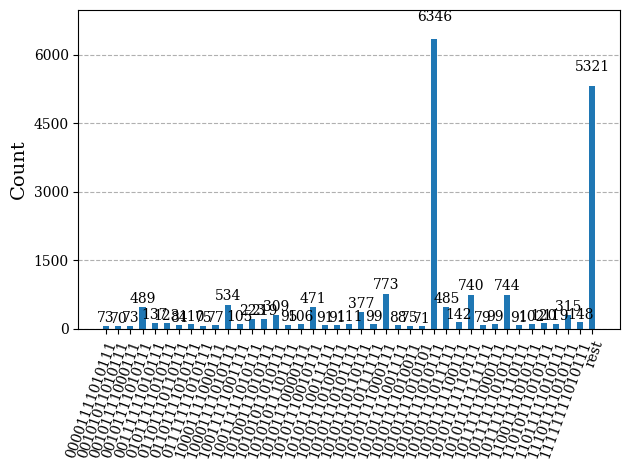

In [163]:
qiskit.visualization.plot_histogram(all_counts[0], number_to_keep=40)

In [164]:
compute_expectation(ham0, all_counts[0])

(-26.123639300482083+0j)

## Begin QEM

## With fractional gates

In [ ]:
job_fractional_gates = sampler_fractional_gates.run([to_run], shots=nshots)

In [ ]:
all_counts_frac = [result.data.measure.get_counts() for result in job_fractional_gates.result()]

In [ ]:
counts_frac = [get_counts_for(c, qubit1, qubit2) for c in all_counts_frac][0]
counts_frac

In [ ]:
exp_zz_frac = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_frac.items()
) / nshots
exp_zz_frac

## With dynamical decoupling

In [ ]:
sampler_dd = Sampler(computer)
sampler_dd.options.dynamical_decoupling.enable = True
sampler_dd.options.dynamical_decoupling.sequence_type = "XpXm"

In [ ]:
job_dd = sampler_dd.run([to_run], shots=nshots)
# job_dd = service.job("d1vvt1okchbs73ca920g")

In [ ]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]

In [ ]:
counts_dd = [get_counts_for(c, qubit1, qubit2) for c in all_counts_dd][0]
counts_dd

In [ ]:
exp_zz_dd = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_dd.items()
) / nshots
exp_zz_dd

## With readout error mitigation

In [ ]:
from qiskit_experiments.library import LocalReadoutError
from qiskit.result.distributions.quasi import QuasiDistribution 

from qiskit_experiments.library.characterization.analysis import LocalReadoutErrorAnalysis

In [ ]:
experiment = LocalReadoutError(qubits)
result = experiment.run(computer)

In [ ]:
mitigator = result.analysis_results("Local Readout Mitigator", dataframe=True).iloc[0].value

In [ ]:
correction_matrices = []
for i in range(len(qubits)):
    correction_matrices.append(mitigator.mitigation_matrix(qubits[i]))

counts_per_bit = []
for i in range(len(qubits)):
    counts_per_bit.append(get_counts_for(all_counts[0],i))

margdist_per_bit = []
for i in range(len(qubits)):
    margdist_per_bit.append(np.array([counts_per_bit[i].get("0"), counts_per_bit[i].get("1")]) / nshots)

corrected_margdist_per_bit = []
for i in range(len(qubits)):
    corrected_margdist_per_bit.append(mitigator.mitigation_matrix(qubits[i]) @ margdist_per_bit[i])

new_bits = []
for i in range(len(qubits)):
    new_bits.append(np.random.choice([0, 1], size=nshots, p=corrected_margdist_per_bit[i]))

corrected_bitstrings = ["".join(str(new_bits[i][j]) for i in range(len(qubits))) for j in range(nshots)]
corrected_counts = Counter(corrected_bitstrings)

In [ ]:
def apply_rem(
    counts: dict[str, int], 
    mitigator: "qiskit_experiments.LocalReadoutMitigator",
    *qubits) -> dict[str: int]:
    counts = get_counts_for(counts, *qubits)
    vec = np.zeros(2 ** len(qubits), dtype=float)
    for bitstring, count in counts.items():
        vec[int(bitstring, 2)] = count
    vec = vec / nshots
    assert np.allclose(vec.sum(), 1.0)

    mitigated_probs_quasi = mitigator.mitigation_matrix(qubits=qubits) @ vec
    mitigated_probs_quasi = QuasiDistribution({i: v for i, v in enumerate(mitigated_probs_quasi)})
    mitigated_counts = {
        bitstring: int(nshots * prob) for bitstring, prob in mitigated_probs_quasi.nearest_probability_distribution().binary_probabilities().items()
    }
    return mitigated_counts

In [ ]:
all_counts_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts]

In [ ]:
exp_zz_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_rem[0].items()
) / nshots
exp_zz_rem

In [ ]:
all_counts_dd_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_dd]

In [ ]:
exp_zz_dd_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_dd_rem[0].items()
) / nshots
exp_zz_dd_rem

## With ZNE

In [ ]:
from mitiq import zne

In [ ]:
qasm2_circuit = qasm2.dumps(compiled)

compiled_cirq = circuit_from_qasm(qasm2_circuit.replace("qregless", "q"))

In [ ]:
scale_factors = [1, 3, 5]

In [ ]:
scaled_circuits_cirq = [zne.scaling.fold_global(compiled_cirq, scale_factor) for scale_factor in scale_factors]

In [ ]:
scaled_circuits = [to_qiskit(circuit) for circuit in scaled_circuits_cirq]
scaled_circuits = qiskit.transpile(
    scaled_circuits,
    backend=computer,
    initial_layout=qubits,
    optimization_level=0,
)

In [ ]:
to_run_scaled = [get_measured_circuit(scaled_circuit) for scaled_circuit in scaled_circuits]

In [ ]:
job_zne = sampler.run(to_run_scaled, shots=nshots)
# job_zne = service.job("d1vvtd1mr05s73a71lbg")

In [ ]:
all_counts_zne = [result.data.measure.get_counts() for result in job_zne.result()]

In [ ]:
counts_zne = [get_counts_for(c, qubit1, qubit2) for c in all_counts_zne]
counts_zne

In [ ]:
exp_zz_vals = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne
]
exp_zz_vals

In [ ]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [ ]:
exp_zz_zne = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals,
    order=2,
)
exp_zz_zne

## ZNE + REM

In [ ]:
counts_zne_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_zne]

In [ ]:
exp_zz_vals_zne_rem = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne_rem
]
exp_zz_vals_zne_rem

In [ ]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [ ]:
exp_zz_zne_rem = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals_zne_rem,
    order=2,
)
exp_zz_zne_rem

## With decoherence renormalization

In [ ]:
from typing import List, Optional


def get_echo_circuit(
    computer: qiskit_ibm_runtime.IBMBackend,
    qubits: List[int],
    depth: int,
    seed: Optional[int] = None,
) -> qiskit.QuantumCircuit:
    """Return a (Loschmidt) echo circuit.

    The circuit is built by applying random single-qubit rotations (angles set by `seed`)
    and layers of two-qubit gates which can be implemented on the `computer` to create a 
    unitary U. Then, the inverse unitary U^dag is applied. 

    Args:
        computer: Determines the implementable gates (unitaries and couplings) for the echo circuit.
        qubits: A subset of qubits on the computer to implement the echo on.
        depth: The number of layers of single-qubit rotations/two-qubit gates in U.
        seed: Determines the angle of rotations for random single-qubit rotations in each layer.
    """
    # Get a random state (determines the angles in single-qubit rotations).
    rng = np.random.RandomState(seed)
    
    # Get the subgraph.
    subgraph_edges = []
    
    for edge in computer.coupling_map.get_edges():
        if edge[0] in qubits and edge[1] in qubits:
            subgraph_edges.append(edge)
    
    graph = nx.Graph()
    graph.add_edges_from(subgraph_edges)
    
    # Get the two-qubit gate from the device. TODO: Handle cases where the two-qubit gate is neither ECR nor CNOT.
    two_qubit_gate = qiskit.circuit.library.ECRGate() if "ecr" in computer.configuration().basis_gates else qiskit.circuit.library.CZGate()
    
    # Group edges into sets in which two-qubit gates can be performed in parallel.
    edge_sets = [set()]
    
    for edge_index, edge in enumerate(graph.edges):
        for i, edge_set in enumerate(edge_sets):
            edge_added_to_a_set = False
            node_list = [e[0] for e in edge_set] + [e[1] for e in edge_set]
            if edge[0] in node_list or edge[1] in node_list:
                continue
            else:
                edge_sets[i].add(edge)
                edge_added_to_a_set = True
                break
    
        if not edge_added_to_a_set:
            edge_sets.append(set())
            edge_sets[-1].add(edge)

    # print("Found edge sets:")
    # print(edge_sets)
    
    # Get a circuit with the qubits on the computer.
    circuit = qiskit.QuantumCircuit()
    circuit = qiskit.transpile(circuit, backend=computer)
    
    rng = np.random.RandomState(seed=seed)
    
    for _ in range(depth):
        for edge_set in edge_sets:
            # Do a layer of single-qubit rotations.
            for qubit in graph.nodes():
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.RZGate(2 * np.pi * rng.normal()), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
    
            # Do a layer of two-qubit gates.
            for edge in edge_set:
                circuit.append(two_qubit_gate, qargs=[circuit.qubits[edge[0]], circuit.qubits[edge[1]]])
    
            # circuit.barrier()
    
    # Add the echo.
    circuit = circuit.compose(circuit.inverse())
    
    # Measure active qubits.
    if depth == 0:
        creg = qiskit.ClassicalRegister(len(graph.nodes()), name="meas")  # Note: This is hardcoded as `"meas"` to match the default name when `qiskit.QuantumCircuit.measure_active` is used.
        circuit.add_register(creg)
        for i, qubit in enumerate(sorted(graph.nodes())):
            circuit.measure(qubit, creg[i])
    else:
        circuit.measure_active()
    
    return circuit

In [ ]:
echo = get_echo_circuit(computer, qubits, depth=4, seed=1)

In [ ]:
echo.count_ops()

In [ ]:
job_echo = sampler.run([echo], shots=nshots)

In [ ]:
all_counts_echo = [result.data.measure.get_counts() for result in job_echo.result()]

In [ ]:
renormalization = 1.0 - all_counts_echo[0].get("0" * len(qubits), 0) / nshots
renormalization

In [ ]:
exp_zz_drn = exp_zz / renormalization
exp_zz_drn

## Plot results

In [ ]:
labels_vals = {
    "Ideal": exp_zz_ideal,
    "Hardware": exp_zz,
    "DD": exp_zz_dd,
    "REM": exp_zz_rem,
    "DD+REM": exp_zz_dd_rem,
    "ZNE": exp_zz_zne,
    "ZNE+REM": exp_zz_zne_rem,
}
colors = ["tab:green", "tab:red", "tab:grey", "tab:orange", "tab:pink", "tab:blue", "salmon"]
vals = list(labels_vals.values())
labels = list(labels_vals.keys())

plt.bar(range(len(vals)), vals, tick_label=labels, color=colors, edgecolor="black", alpha=0.75)
plt.ylabel(r"$\langle ZZ \rangle$");
plt.savefig("hchain_qem_v4.pdf")